<a href="https://colab.research.google.com/github/apmoore1/target-extraction/blob/master/tutorials/Load_and_Explore_Target_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%%capture
!pip install git+git://github.com/apmoore1/target-extraction.git@master#egg=target-extraction
!pip install altair

In [59]:
from collections import defaultdict
from typing import Callable, Dict, List, Optional

from target_extraction.data_types import TargetTextCollection
from target_extraction.dataset_parsers import semeval_2014, semeval_2016
from target_extraction.dataset_parsers import wang_2017_election_twitter_train
from target_extraction.dataset_parsers import wang_2017_election_twitter_test
import pandas as pd
import altair as alt

alt.renderers.enable('html')

RendererRegistry.enable('html')

# Loads and explore datasets
In this notebook we will show you how to load three of the popular SemEval datasets as well as the election Twitter dataset of [Wang et al. 2017](https://www.aclweb.org/anthology/E17-1046) into the TargetTextCollection object format. Next we will show you the advantage of this easy to use format through serveral built in functions such as:

1. Dataset Statistics -- counts of sentences and targets.
2. Built in tokenization and POS tagging.
3. Import and export to JSON format which is useful if you want to use the data in an [AllenNLP model](https://allennlp.org/)
4. Setting the task of Target Extraction into a Sequence Labelling task

## Loading datasets
First we are going to show you how to load the following popular datasets:
1. [SemEval 2014 task 4 Laptop domain (laptop)](http://alt.qcri.org/semeval2014/task4/). Of which the training data can be found [here](http://metashare.ilsp.gr:8080/repository/browse/semeval-2014-absa-train-data-v20-annotation-guidelines/683b709298b811e3a0e2842b2b6a04d7c7a19307f18a4940beef6a6143f937f0/) and the test data [here](http://metashare.ilsp.gr:8080/repository/browse/semeval-2014-absa-test-data-gold-annotations/b98d11cec18211e38229842b2b6a04d77591d40acd7542b7af823a54fb03a155/).
2. [SemEval 2014 task 4 Restaurant domain (restaurant_14)](http://alt.qcri.org/semeval2014/task4/). Of which the training and the test data can be found at the same place as the laptop dataset.
3. [SemEval 2016 task 5 Restaurant domain (restaurant_16)](http://alt.qcri.org/semeval2016/task5/). Of which the training data can be found [here](http://metashare.ilsp.gr:8080/repository/browse/semeval-2016-absa-restaurant-reviews-english-train-data-subtask-1/cd28e738562f11e59e2c842b2b6a04d703f9dae461bb4816a5d4320019407d23/) and the test data [here](http://metashare.ilsp.gr:8080/repository/browse/semeval-2016-absa-restaurant-reviews-english-test-data-gold-subtask-1/42bd97c6d17511e59dbe842b2b6a04d721d1933085814d9daed8fbcbe54c0615/).
4. The election Twiiter dataset of [Wang et al. 2017](https://www.aclweb.org/anthology/E17-1046) (Election Twitter) can be automatically downloaded, so no need to worry about downloading this dataset manually.

Assuming you have downloaded these files we will now upload them to this notebook, this will require 6 upload requests which will happen when you run the next cell; 1. The training, 2. test data for the laptop domain, 3. the training data, 4. test data for the restaurant_14, 5. the training data, and 6. test data for the restaurant_16

In [3]:
from pathlib import Path
from google.colab import files
uploaded = {}
for i in range(6):
  temp_uploaded = files.upload()
  uploaded = {**uploaded, **temp_uploaded}
semeval_fps = [Path(key).resolve() for key in uploaded.keys()]
semeval_fps = {semeval_path.name: semeval_path for semeval_path in semeval_fps}
del uploaded
# Paths to the files uploaded
for file_name, fp in semeval_fps.items():
  print(f'SemEval file name: {file_name}. File Path {fp}')

Saving Restaurants_Train_v2.xml to Restaurants_Train_v2.xml


Saving Laptop_Train_v2.xml to Laptop_Train_v2.xml


Saving Restaurants_Test_Gold.xml to Restaurants_Test_Gold.xml


Saving Laptops_Test_Gold.xml to Laptops_Test_Gold.xml


Saving ABSA16_Restaurants_Train_SB1_v2.xml to ABSA16_Restaurants_Train_SB1_v2.xml


Saving EN_REST_SB1_TEST.xml.gold to EN_REST_SB1_TEST.xml.gold
SemEval file name: Restaurants_Train_v2.xml. File Path /content/Restaurants_Train_v2.xml
SemEval file name: Laptop_Train_v2.xml. File Path /content/Laptop_Train_v2.xml
SemEval file name: Restaurants_Test_Gold.xml. File Path /content/Restaurants_Test_Gold.xml
SemEval file name: Laptops_Test_Gold.xml. File Path /content/Laptops_Test_Gold.xml
SemEval file name: ABSA16_Restaurants_Train_SB1_v2.xml. File Path /content/ABSA16_Restaurants_Train_SB1_v2.xml
SemEval file name: EN_REST_SB1_TEST.xml.gold. File Path /content/EN_REST_SB1_TEST.xml.gold


We will now load the data into TargetTextCollection format:

NOTE: The `conflict` argument states whether or not to include targets or categories that contain the `conflict` sentiment. In this case we **do** want the `conflict` sentiment targets or categories thus the value is `True`

In [0]:
laptop_train = semeval_2014(semeval_fps['Laptop_Train_v2.xml'], conflict=True)
laptop_test = semeval_2014(semeval_fps['Laptops_Test_Gold.xml'], conflict=True)
rest_14_train = semeval_2014(semeval_fps['Restaurants_Train_v2.xml'], conflict=True)
rest_14_test = semeval_2014(semeval_fps['Restaurants_Test_Gold.xml'], conflict=True)
rest_16_train = semeval_2016(semeval_fps['ABSA16_Restaurants_Train_SB1_v2.xml'], conflict=True)
rest_16_test = semeval_2016(semeval_fps['EN_REST_SB1_TEST.xml.gold'], conflict=True)

As I stated earlier the Election Twitter dataset is automatically downloaded and put within the following `cache_dir` `$HOME/.bella_tdsa/Wang 2017 Election Twitter`

In [0]:
election_train = wang_2017_election_twitter_train()
election_test = wang_2017_election_twitter_test()

In [0]:
def target_lengths(dataset: TargetTextCollection, 
                   tokenizer: Callable[[str], List[str]],
                   cumulative_percentage: bool = False) -> Dict[int, int]:
  '''
  :param dataset: The dataset
  :param tokenizer: The tokenizer to use to split the target into tokens
  :param cumulative_percentage: If the return should not be frequency counts of 
                                the number of targets but the cumulative 
                                percentage of targets with that number of tokens.
  :returns: The dictionary where keys are the target length based on the number 
            of tokens in the target and the values are the number of targets 
            in the dataset that contain that number of tokens (same target can 
            be counted more than once if it exists in the dataset more then 
            once).
  '''
  lengths = defaultdict(lambda: 0)
  for target, count in dataset.target_count().items():
    length = len(tokenizer(target))
    lengths[length] += count
  if cumulative_percentage:
    total_target_count = sum(lengths.values())
    lengths = sorted(lengths.items(), key=lambda x: x[0])
    temp_lengths = {}
    current_percentage = 0.0
    for length, count in lengths:
      percentage = (count/total_target_count) * 100
      temp_lengths[length] = current_percentage + percentage
      current_percentage += percentage
    lengths = temp_lengths
  return lengths

def target_length_dist_chart(target_length_frame: pd.DataFrame, title: str,
                             target_limit: Optional[int] = None
                             ) -> alt.vegalite.v4.api.Chart:
  '''
  :param error_type_frame: A DataFrame containing the following columns: 
                           1. Error Type, 2. Number of Samples (%),
                           3. Number of Samples, 4. Dataset
  :param title: A title to give to the generated plot
  :param no_labels: Whether the Y-axis should have a label displayed
  :returns: A plot that displays for each of the datasets the percentage of the 
            error types in that dataset as stacked coloured coloumns.
  '''
  # Plot error type data
  font_size = 14
  y_axis_color = alt.Color('Dataset')
  y_axis = alt.Axis(title=None, labels=True, ticks=False)
  y_col = alt.Y('Percentage',
                scale=alt.Scale(domain=[60, 100]))
  
  largest_target_length = int(target_length_frame['Target Length'].max())
  if target_limit is not None:
    largest_target_length = target_limit
  x_col = alt.X('Target Length', scale=alt.Scale(domain=[1, largest_target_length]))
  target_length_frame = target_length_frame[target_length_frame['Target Length'] 
                                            <= largest_target_length]
        
  tooltip=['Percentage', 'Target Length', 'Dataset']
  target_length_bar_data = {'x': x_col, 'y': y_col, 
                            'color': y_axis_color, 'tooltip': tooltip}
  
  chart= alt.Chart(target_length_frame).mark_line(point=True)\
                                       .encode(**target_length_bar_data)
  chart.title = title
  return chart
  

## Dataset Statistics

Now that we have loaded these datasets we can perform some dataset statistics on them, such as the number of sentences, number of sentences that contain at least one target in it, and the number of  targets in the dataset, finally the number of unique targets.

In [8]:
from collections import defaultdict
import pandas as pd

name_dataset = [('Laptop Train', laptop_train), ('Laptop Test', laptop_test),
                ('Restaurant 14 Train', rest_14_train), 
                ('Restaurant 14 Test', rest_14_test),
                ('Restaurant 16 Train', rest_16_train), 
                ('Restaurant 16 Test', rest_16_test),
                ('Election Twitter Train', election_train),
                ('ELection Twitter Test', election_test)]
dataset_stats = defaultdict(lambda: {})

for name, dataset in name_dataset:
  num_sentences = len(dataset)
  num_targ_sents = len(dataset.samples_with_targets())
  num_targs = dataset.number_targets(incl_none_targets=False)
  num_unique_targets = len(dataset.target_count(lower=True))
  
  dataset_stats[name]['Number Sentences'] = num_sentences
  dataset_stats[name]['Number Target Sentences'] = num_targ_sents
  dataset_stats[name]['Number Targets'] = num_targs
  dataset_stats[name]['Number Uniq Targets'] = num_unique_targets
pd.DataFrame(dataset_stats).T  

,Number Sentences,Number Target Sentences,Number Targets,Number Uniq Targets
Laptop Train,3045,1488,2358,955
Laptop Test,800,422,654,393
Restaurant 14 Train,3041,2021,3693,1212
Restaurant 14 Test,800,606,1134,522
Restaurant 16 Train,2000,1708,1883,675
Restaurant 16 Test,676,587,651,289
Election Twitter Train,3210,3182,9358,1849
ELection Twitter Test,867,863,2541,751


These statistics match those of the original SemEval task 4 subtask 1 2014 Laptop/Restaurant dataset [paper](https://www.aclweb.org/anthology/S14-2004), and original SemEval task 5 subtask 1 2016 Restaurant dataset [paper](https://www.aclweb.org/anthology/S16-1002). The statistics for Twitter Election do not match those of the original [paper](https://www.aclweb.org/anthology/E17-1046) but do match those from [Moore et al, 2018 paper](https://www.aclweb.org/anthology/C18-1097) that replicated the experiments and within that paper explains why it does not match the original.

However the Restaurant 2016 dataset is reporting the number of (targets, categories) which means that for the target extraction task this is not ideal as we can have duplicate targets with the same spans in the same sentence as each one of those duplicate targets can have a different category. An example of this is shown below:

In [9]:
sample = rest_16_train['1086415:2']
sample

TargetText({'text': '$6 and there is much tasty food, all of it fresh and continually refilled.', 'text_id': '1086415:2', 'targets': ['food', 'food', 'food'], 'spans': [Span(start=27, end=31), Span(start=27, end=31), Span(start=27, end=31)], 'target_sentiments': ['positive', 'positive', 'positive'], 'categories': ['FOOD#STYLE_OPTIONS', 'FOOD#QUALITY', 'FOOD#PRICES'], 'category_sentiments': None})

As we can see in the example above the target food with the eaxct same span is used three times as each time it has a different category associated to it. To convert the dataset into one that only allows one target with one span use the `one_sample_per_span` function to create a new TargetTextCollection dataset (NOTE: This is only required for the Restaurant 2016 dataset as the previous datasets did not link the target and categories together):



In [10]:
rest_target_16_train = rest_16_train.one_sample_per_span(remove_empty=True)
rest_target_16_test = rest_16_test.one_sample_per_span(remove_empty=True)

sample = rest_target_16_train['1086415:2']
sample

TargetText({'text': '$6 and there is much tasty food, all of it fresh and continually refilled.', 'text_id': '1086415:2', 'targets': ['food'], 'spans': [Span(start=27, end=31)], 'target_sentiments': None, 'categories': None, 'category_sentiments': None})

As we can see above the TargetText instance now only has `food` once but we have had to remove all of the category information and sentiment. However this is perfect if we want to just perform the Target Extraction task. 

NOTE: The `remove_empty=True` argument is required as some of the (target, category) pairs contain targets that are None as in the target does not exist but the category does therefore setting this argument to `True` removes these None targets

In [11]:
name_dataset = [('Laptop Train', laptop_train), ('Laptop Test', laptop_test),
                ('Restaurant 14 Train', rest_14_train), 
                ('Restaurant 14 Test', rest_14_test),
                ('Restaurant 16 Train', rest_target_16_train), 
                ('Restaurant 16 Test', rest_target_16_test),
                ('Election Twitter Train', election_train),
                ('Election Twitter Test', election_test)] 
dataset_stats = defaultdict(lambda: {})

for name, dataset in name_dataset:
  num_sentences = len(dataset)
  num_targ_sents = len(dataset.samples_with_targets())
  num_targs = dataset.number_targets()
  
  dataset_stats[name]['Number Sentences'] = num_sentences
  dataset_stats[name]['Number Target Sentences'] = num_targ_sents
  dataset_stats[name]['Number Targets'] = num_targs
pd.DataFrame(dataset_stats).T  

,Number Sentences,Number Target Sentences,Number Targets
Laptop Train,3045,1488,2358
Laptop Test,800,422,654
Restaurant 14 Train,3041,2021,3693
Restaurant 14 Test,800,606,1134
Restaurant 16 Train,2000,1235,1745
Restaurant 16 Test,676,421,613
Election Twitter Train,3210,3182,9358
Election Twitter Test,867,863,2541


Now that we have re-run the statistics of the dataset we can see that the Restaurant dataset has changed with regards to the Number of targets and target sentences. These statistics are now more in line with previous work ([link](https://www.aclweb.org/anthology/D17-1310) [link](https://www.aclweb.org/anthology/N19-1242)). However there are some reasons why they are not identical only for the Restaurant 2016 dataset, these are artifacts in the original annotation that we found which we share below:

### First annotation mistake
This is the case where the annotation stats NULL for the target but give a Span value:

``` xml
<sentence id="en_SchoonerOrLater_477965850:10">
  <text>In short, Schooner or Later couldn't have cared less about our being at their establishment.</text>
  <Opinions>
    <Opinion target="NULL" category="SERVICE#GENERAL" polarity="negative" from="10" to="27"/>
  </Opinions>
</sentence>
```
In these cases we change target from `NULL` to `Schooner or Later` and more generally to the text that the span refers to.

These mistakes add more targets to the dataset of which in the Restaurant train and test dataset there were 3 (1 of which linked to an exisitng target as in that target now existed twice with difference categories) and 1 mistakes respectively.

### Second annotation mistake
Annotation stats NULL for the target but the Span value is given but makes no sense:

``` xml
<sentence id="en_MercedesRestaurant_478010600:1">
  <text>– !</text>
  <Opinions>
    <Opinion target="service" category="SERVICE#GENERAL" polarity="positive" from="39" to="46"/>
    <Opinion target="NULL" category="FOOD#QUALITY" polarity="positive" from="2" to="21"/>
  </Opinions>
</sentence>
```
As we can see that there is a target which is `NULL` but the spans refers to the following text `rcedes restaurant i` which just makes no sense. Therefore in these cases we leave the target as it does not exist and change the spans to `from = 0` and `to = 0`. In these case they do not affect the overall statistics it just highlights mistakes that have been made. In the Restaurant train and test dataset there were 1 and 4 mistakes respectively.

### Furthermore...
We found that in the SemEval 2014 Laptop domain dataset there is actually a sample that is in both Train and Test datasets:



In [12]:
laptop_train_ids = set(list(laptop_train.keys()))
laptop_test_ids = set(list(laptop_test.keys()))
id_in_both_train_test = laptop_test_ids.intersection(laptop_train_ids)
id_in_both_train_test = list(id_in_both_train_test)[0]
print(f'The ID that is in both Laptop train and test {id_in_both_train_test}')
print(f'As shown the Sample in the Train:\n{laptop_train[id_in_both_train_test]}')
print(f'As shown the Sample in the Test:\n{laptop_test[id_in_both_train_test]}')

The ID that is in both Laptop train and test 227
As shown the Sample in the Train:
TargetText({'text': 'If you want more information on macs I suggest going to apple.com and heading towards the macbook page for more information on the applications.', 'text_id': '227', 'targets': ['applications'], 'spans': [Span(start=131, end=143)], 'target_sentiments': ['neutral'], 'categories': None, 'category_sentiments': None})
As shown the Sample in the Test:
TargetText({'text': 'If you want more information on macs I suggest going to apple.com and heading towards the macbook page for more information on the applications.', 'text_id': '227', 'targets': ['applications'], 'spans': [Span(start=131, end=143)], 'target_sentiments': ['neutral'], 'categories': None, 'category_sentiments': None})


### Lastly we are going to look at the distribution of sentiment labels
It has been shown in prior work that the datasets are in-balanced with respect to the sentiment labels. Here we are going to show this for each of the datasets:

In [15]:
from collections import Counter

def count_sentiments(dataset: TargetTextCollection) -> Dict[str, int]:
  sentiment_count = Counter()
  for target in dataset.samples_with_targets().values():
    sentiment_count.update(target['target_sentiments'])
  return sentiment_count

in_balanced_stats = defaultdict(lambda: {})

for name, dataset in name_dataset:
  # Have to skip the Restaurant 16 dataset as we had to remove the sentiment 
  # labels to ensure that each target only occured once
  if '16' in name:
    continue
  sentiment_counts = count_sentiments(dataset)
  total_count = sum(sentiment_counts.values())
  percentages = {sentiment: round((count/total_count)*100,2) 
                 for sentiment, count in sentiment_counts.items()}
  
  in_balanced_stats[name]['Number Positive (%)'] = f"{sentiment_counts['positive']} ({percentages['positive']})"
  in_balanced_stats[name]['Number Neutral (%)'] = f"{sentiment_counts['neutral']} ({percentages['neutral']})"
  in_balanced_stats[name]['Number Negative (%)'] = f"{sentiment_counts['negative']} ({percentages['negative']})"
  if 'conflict' in percentages:
    in_balanced_stats[name]['Number Conflict (%)'] = f"{sentiment_counts['conflict']} ({percentages['conflict']})"
  else:
    in_balanced_stats[name]['Number Conflict (%)'] = f"0 (0)"
pd.DataFrame(in_balanced_stats).T  

,Number Positive (%),Number Neutral (%),Number Negative (%),Number Conflict (%)
Laptop Train,987 (41.86),460 (19.51),866 (36.73),45 (1.91)
Laptop Test,341 (52.14),169 (25.84),128 (19.57),16 (2.45)
Restaurant 14 Train,2164 (58.6),633 (17.14),805 (21.8),91 (2.46)
Restaurant 14 Test,728 (64.2),196 (17.28),196 (17.28),14 (1.23)
Election Twitter Train,1366 (14.6),3615 (38.63),4377 (46.77),0 (0)
Election Twitter Test,378 (14.88),957 (37.66),1206 (47.46),0 (0)


As we can see from above non of the dataset are balanced with respect to sentiment and the Restaurant dataset would appear to be the worse where the positive class represents over 50% of the samples. However the conflict label is very under represented and therefore is usual ignored/removed when performing sentiment analysis in TDSA.

## Tokenization

The `target_extraction` has a few tokenization options avaliable:
1. [Spacy](https://spacy.io/) -- Rule based tokenizer. 
2. [Stanford](https://stanfordnlp.github.io/stanfordnlp/), related [paper](https://www.aclweb.org/anthology/K18-2016) -- Neural Network based tokenizer.
3. [Twokenize](https://github.com/brendano/ark-tweet-nlp) [related paper](https://www.cs.cmu.edu/~ark/TweetNLP/gimpel+etal.acl11.pdf) -- Twitter based tokenizer.
4. Whitespace.

Both the Spacy and Stanford tokenizers support multiple languages.

To use any of the tokenizers we have to call the tokenizers method to get a related tokenizer as shown below:

In [16]:
from target_extraction import tokenizers

example_sentence = "I've had a great day today. The tokenizer's work well."

# Get different spacy tokenizers
# English is the default language
spacy_tok_en = tokenizers.spacy_tokenizer()
# German
spacy_tok_de = tokenizers.spacy_tokenizer(lang='de')


# Get different Stanford tokenizers
# English again is the default language and the default treebank is EWT
stanford_tok_en = tokenizers.stanford()
# Dutch but with a treebank that is not default
stanford_tok_nl = tokenizers.stanford(lang='nl', treebank='lassysmall')

twitter_tok = tokenizers.ark_twokenize()

# Whitespace
whitespace_tok = tokenizers.whitespace()

print(f'Spacy: {spacy_tok_en(example_sentence)}')
print(f'Stanford: {stanford_tok_en(example_sentence)}')
print(f'Twokenize {twitter_tok(example_sentence)}')
print(f'Whitespace {whitespace_tok(example_sentence)}')


Would you like to download the models for: en_ewt now? (Y/n)

Default download directory: /root/stanfordnlp_resources
Hit enter to continue or type an alternate directory.

Download location: /root/stanfordnlp_resources/en_ewt_models.zip


100%|██████████| 235M/235M [00:04<00:00, 48.5MB/s]



Download complete.  Models saved to: /root/stanfordnlp_resources/en_ewt_models.zip
Extracting models file for: en_ewt
Cleaning up...Done.
Use device: cpu
---
Loading: tokenize
With settings: 
{'model_path': '/root/stanfordnlp_resources/en_ewt_models/en_ewt_tokenizer.pt', 'lang': 'en', 'shorthand': 'en_ewt', 'mode': 'predict'}
Done loading processors!
---
Would you like to download the models for: nl_lassysmall now? (Y/n)

Default download directory: /root/stanfordnlp_resources
Hit enter to continue or type an alternate directory.

Download location: /root/stanfordnlp_resources/nl_lassysmall_models.zip


100%|██████████| 223M/223M [00:06<00:00, 33.5MB/s]



Download complete.  Models saved to: /root/stanfordnlp_resources/nl_lassysmall_models.zip
Extracting models file for: nl_lassysmall
Cleaning up...Done.
Use device: cpu
---
Loading: tokenize
With settings: 
{'model_path': '/root/stanfordnlp_resources/nl_lassysmall_models/nl_lassysmall_tokenizer.pt', 'lang': 'nl', 'shorthand': 'nl_lassysmall', 'mode': 'predict'}
Done loading processors!
---
Spacy: ['I', "'ve", 'had', 'a', 'great', 'day', 'today', '.', 'The', 'tokenizer', "'s", 'work', 'well', '.']
Stanford: ['I', "'ve", 'had', 'a', 'great', 'day', 'today', '.', 'The', 'tokenizer', "'s", 'work', 'well', '.']
Twokenize ["I've", 'had', 'a', 'great', 'day', 'today', '.', 'The', "tokenizer's", 'work', 'well', '.']
Whitespace ["I've", 'had', 'a', 'great', 'day', 'today.', 'The', "tokenizer's", 'work', 'well.']


As we can see the Spacy and the Stanford tokenizers are more similar than the whitespacy with regards to handling full stops and hyphons.

We can also use these tokenizers to tokenizse the whole of our datasets easily as shown below (in the example below we use the Spacy tokenizer):

In [17]:
# Tokenize each dataset
for name, dataset in name_dataset:
  print(name)
  dataset.tokenize(spacy_tok_en)

sample = rest_target_16_train['1086415:2']
print(f"Text: {sample['text']}\nTokens: {sample['tokenized_text']}")

Laptop Train
Laptop Test
Restaurant 14 Train
Restaurant 14 Test
Restaurant 16 Train
Restaurant 16 Test
Election Twitter Train
Election Twitter Test
Text: $6 and there is much tasty food, all of it fresh and continually refilled.
Tokens: ['$', '6', 'and', 'there', 'is', 'much', 'tasty', 'food', ',', 'all', 'of', 'it', 'fresh', 'and', 'continually', 'refilled', '.']


We see that within the TargetTextCollection each sample now has a new property (key in the internal disctionary) `tokenized_text` which contains the tokenized text for that sample.

### Target Length Distribution
Now that we know how to use the tokenizers we are going to use the Spacy tokenizer to explore the Target length distribution in the training datasets. The Target length distribution where the length of the Target is defined by the number words that make up the target.

In [62]:
training_datasets = [('Laptop Train', laptop_train), ('Restaurant 14 Train', rest_14_train), 
                     ('Restaurant 16 Train', rest_target_16_train), 
                     ('Election Twitter Train', election_train)]
dataset_names = []
lengths = []
percentages = []

for name, dataset in training_datasets:
  for target_length, percentage in target_lengths(dataset, spacy_tok_en, True).items():
    dataset_names.append(name)
    lengths.append(target_length)
    percentages.append(percentage)
target_length_df =  pd.DataFrame({'Target Length': lengths, 'Dataset': dataset_names, 'Percentage': percentages})
target_length_dist_chart(target_length_df, 
                         'Target length cumulative distribution', 6).interactive()

alt.Chart(...)

We can see that at least 95% of the targets in the training dataset have a token length between 1 and 3 in all of the datasets. Below we show what the cummulative target distribution is for all of the target lengths (interactive chart so you can zoom in and move the chart around):

In [26]:
target_length_dist_chart(target_length_df, 
                         'Target length cumulative distribution').interactive()

alt.Chart(...)

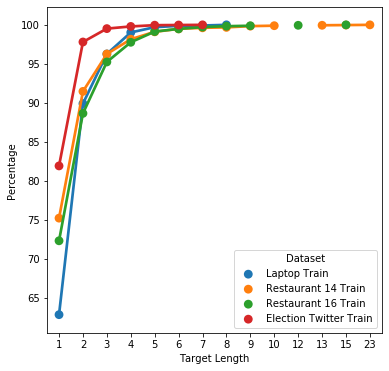

In [76]:
# This is a seaborn version of the above plot that will render in Github
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize=(6,6))
_ = sns.pointplot(data=target_length_df, x='Target Length', y='Percentage', 
                  hue='Dataset', ax=ax)

From the chart above we can see that the 2014 Restaurant dataset has the longest target (23), Restaurant 16 (15),  Laptop (8), and the Election Twitter (7).

## POS Tagging
The `target_extraction` has a couple of POS tagging options avaliable:
1. [Spacy](https://spacy.io/) -- Neural Network based. 
2. [Stanford](https://stanfordnlp.github.io/stanfordnlp/), related [paper](https://www.aclweb.org/anthology/K18-2016) -- Neural Network based.

Both the Spacy and Stanford POS taggers support multiple languages. They also both support two different types of tag sets:
1. [Universal POS tags (coarse)](https://universaldependencies.org/u/pos/) -- These are the same tags accross languages.
2. Language Specific (fine) -- These are language independent tags and are usuall more fine grained than the Universal, an example of this tag set would be the [Penn Treebank](https://www.clips.uantwerpen.be/pages/mbsp-tags).

**NOTE** Currently we have not got a POS tagger for the Twitter social media texts.

To use any of the POS taggers we have to call the POS tagger's method to get the related POS tagger as shown below:

In [27]:
from target_extraction import pos_taggers

example_sentence = "I've had a great day today. The tokenizer's work well."

# Get different spacy tokenizers
# English is the default language with the small model and here we have chosen 
# the universal tag set
spacy_pos_en = pos_taggers.spacy_tagger(fine=False)
# German with the small model and language independent tag set
spacy_pos_de = pos_taggers.spacy_tagger(spacy_model_name='de_core_news_sm', 
                                        fine=True)


# Get different Stanford tokenizers
# English again is the default language and the default treebank is EWT, 
# using language independent tag set.
stanford_pos_en_fine = pos_taggers.stanford(fine=True)
# Dutch but with a treebank that is not default and language independent tag set
stanford_pos_nl = pos_taggers.stanford(lang='nl', treebank='lassysmall', fine=True)
# English again is the default language and the default treebank is EWT, 
# using the universal tag set
stanford_pos_en_coarse = pos_taggers.stanford(fine=False)

print(f'Stanford Language Independent: {stanford_pos_en_fine(example_sentence)}')
print(f'Stanford Universal: {stanford_pos_en_coarse(example_sentence)}')
print(f'Spacy: {spacy_pos_en(example_sentence)}')


Spacy models 'de_core_news_sm' not found. Downloading and installing.
✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/de_core_news_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/de_core_news_sm
You can now load the model via spacy.load('de_core_news_sm')
Use device: cpu
---
Loading: tokenize
With settings: 
{'model_path': '/root/stanfordnlp_resources/en_ewt_models/en_ewt_tokenizer.pt', 'lang': 'en', 'shorthand': 'en_ewt', 'mode': 'predict'}
---
Loading: pos
With settings: 
{'model_path': '/root/stanfordnlp_resources/en_ewt_models/en_ewt_tagger.pt', 'pretrain_path': '/root/stanfordnlp_resources/en_ewt_models/en_ewt.pretrain.pt', 'lang': 'en', 'shorthand': 'en_ewt', 'mode': 'predict'}
Done loading processors!
---
Use device: cpu
---
Loading: tokenize
With settings: 
{'model_path': '/root/stanfordnlp_resources/nl_lassysmall_models/nl_lassysmall_tokenizer.pt', 'lang': '

We can easily see the difference between the universal and independent tag sets.

Like the tokenizers we can easily POS tag the whole dataset as shown below: 

**NOTE** You can call the POS taggers without having to call the tokenizers and it will POS tag and re-tokenize the text so that the tokenized tokens match the POS tags.

In [28]:
# POS tag each dataset
for name, dataset in name_dataset:
  print(name)
  dataset.pos_text(spacy_pos_en)

sample = rest_target_16_train['1086415:2']
print(f"Text: {sample['text']}\nTokens: {sample['tokenized_text']}\nPOS tags: {sample['pos_tags']}")

Laptop Train
Laptop Test
Restaurant 14 Train
Restaurant 14 Test
Restaurant 16 Train
Restaurant 16 Test
Election Twitter Train
Election Twitter Test
Text: $6 and there is much tasty food, all of it fresh and continually refilled.
Tokens: ['$', '6', 'and', 'there', 'is', 'much', 'tasty', 'food', ',', 'all', 'of', 'it', 'fresh', 'and', 'continually', 'refilled', '.']
POS tags: ['SYM', 'NUM', 'CCONJ', 'ADV', 'VERB', 'ADJ', 'ADJ', 'NOUN', 'PUNCT', 'DET', 'ADP', 'PRON', 'ADJ', 'CCONJ', 'ADV', 'VERB', 'PUNCT']


## To and From JSON

Once loaded into the TargetTextCollection format it is easy to export to JSON format and import into a TargetTextCollection from JSON as shown below:

In [29]:
from target_extraction.data_types import TargetTextCollection

example_json = laptop_train.to_json()[:200]
print(f'Sample of the JSON: {example_json}')
empty_collection = TargetTextCollection.from_json(laptop_train.to_json())
empty_collection == laptop_train

Sample of the JSON: {"text": "I charge it at night and skip taking the cord with me because of the good battery life.", "text_id": "2339", "targets": ["cord", "battery life"], "spans": [[41, 45], [74, 86]], "target_senti


True

As we can see above we can export to a JSON string and import from a JSON string. Below we show similar methods but instead of exporting and importing from Strings we do this from Files or more specifically File Paths:

In [30]:
from pathlib import Path
import tempfile

with tempfile.NamedTemporaryFile(mode='w+') as temp_file:
  temp_fp = Path(temp_file.name)
  laptop_train.to_json_file(temp_fp)
  empty_collection = None
  empty_collection = TargetTextCollection.load_json(temp_fp)
  print(empty_collection == laptop_train)

True


And as expected the TargetTextCollection loaded from the JSON file is the same as the one that exported it into JSON.

## Creating the sequence labelling task for Target Extraction and the True Upper limit
The Target Extraction (TE) task within Aspect Based Sentiment Analysis (ABSA) is normally formulated as a Sequence Labelling task ([paper link](https://www.aclweb.org/anthology/P18-2094)), however unlike other sequence labelling problems that have pre-tokenized text with gold sequence labels like [NER](https://www.aclweb.org/anthology/P16-1101) TE is evaluated based on Eaxct Span Matching not Sequence Labels.

This means that if we do treat the task as a sequence labelling task we can have tokenization errors and we show this below and thus show (we believe) for the first time the true upper limit of TE when treating it as a sequence labelling task due to tokenization error.

In [31]:
# Just to let you know for the Future to perform sequence_labels it requires
# you to tokenize the TargetTextCollection first

sequence_label_errors = {}
for name, dataset in name_dataset:
  print(name)
  # Return errors shows if any samples have overlapping targets
  return_errors = dataset.sequence_labels(return_errors=True)
  sequence_label_errors[name] = return_errors
sample = rest_target_16_train['1086415:2']
print(sample['sequence_labels'])
print(sample['tokenized_text'])
print(sample['targets'])
print(sample['spans'])

Laptop Train
Laptop Test
Restaurant 14 Train
Restaurant 14 Test
Restaurant 16 Train
Restaurant 16 Test
Election Twitter Train
Election Twitter Test
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['$', '6', 'and', 'there', 'is', 'much', 'tasty', 'food', ',', 'all', 'of', 'it', 'fresh', 'and', 'continually', 'refilled', '.']
['food']
[Span(start=27, end=31)]


### Errors when creating the sequence labelling task

We next want to check if any of our datasets had any errors when creating the sequence labels:

In [32]:
for dataset_name, return_errors in sequence_label_errors.items():
  print(f'Dataset {dataset_name}, number of errors: {len(return_errors)}')

Dataset Laptop Train, number of errors: 0
Dataset Laptop Test, number of errors: 0
Dataset Restaurant 14 Train, number of errors: 0
Dataset Restaurant 14 Test, number of errors: 0
Dataset Restaurant 16 Train, number of errors: 0
Dataset Restaurant 16 Test, number of errors: 0
Dataset Election Twitter Train, number of errors: 6
Dataset Election Twitter Test, number of errors: 2


As we can see only the Election Twitter dataset has these Sequence Label Errors of which an example of one can be seen below:

In [33]:
sequence_label_errors['Election Twitter Train'][2]

TargetText({'text': '.@George_Osborne reiterates pledge to raise the personal income tax allowance to £12.5k, if the Tories win the #GE2015. #Budget2015 #Marr', 'text_id': '77050468909772800', 'targets': ['@George_Osborne', 'income tax', 'Budget2015', 'tax allowance', 'Tories'], 'spans': [Span(start=1, end=16), Span(start=57, end=67), Span(start=121, end=131), Span(start=64, end=77), Span(start=96, end=102)], 'target_sentiments': ['positive', 'positive', 'positive', 'positive', 'positive'], 'categories': None, 'category_sentiments': None, 'tokenized_text': ['.@George_Osborne', 'reiterates', 'pledge', 'to', 'raise', 'the', 'personal', 'income', 'tax', 'allowance', 'to', '£', '12.5k', ',', 'if', 'the', 'Tories', 'win', 'the', '#', 'GE2015', '.', '#', 'Budget2015', '#', 'Marr'], 'pos_tags': ['ADV', 'NOUN', 'VERB', 'PART', 'VERB', 'DET', 'ADJ', 'NOUN', 'NOUN', 'NOUN', 'ADP', 'NOUN', 'NUM', 'PUNCT', 'ADP', 'DET', 'PROPN', 'VERB', 'DET', 'SYM', 'NOUN', 'PUNCT', 'SYM', 'PROPN', 'NOUN', 'PROPN

Where in the example above there are two targets that overlap with each other: `income tax` and `tax allowance`

This is a problem for sequence labelling as we would treat this as a BIO labelling task and if there is overlap as shown above we don't know if we should label `tax` as an `I` in the case of `income tax` or a `B` in the case of `tax allowance`. Therefore to avoid this problem we are going to remove these samples from our Election Train and Test datasets:

In [34]:
print(len(election_train))
election_train_errors = sequence_label_errors['Election Twitter Train']
for error in election_train_errors:
  del election_train[error['text_id']]
print(len(election_train))

print(len(election_test))
election_test_errors = sequence_label_errors['Election Twitter Test']
for error in election_test_errors:
  del election_test[error['text_id']]
print(len(election_test))

3210
3204
867
865


### Tokenization errors example in detail
Above we have used the Gold Spans to create the sequence labels based on the tokenization and we have printed the sequence labels, tokens, and the Gold Spans and in this case the Spans align perfectly with the tokens. However the assumption I think in the field is that tokenization does not cause any errors but this is not True as not all tokens perfectly align with the Gold Spans an example of this is shown below. 

In [35]:
measures = laptop_train.exact_match_score('sequence_labels')
recall, precision, f1, errors_analysis = measures
print(f'Recall: {recall:.3f}\nPrecision: {precision:.3f}\nF1: {f1:.3f}\n')

false_positive_mistakes = errors_analysis['FP']
false_negative_mistakes = errors_analysis['FN']
print(f'Example of mistake return {false_positive_mistakes[0]}')
fp_sample_mistake_id = false_positive_mistakes[0][0]
fp_sample_mistake_span = false_positive_mistakes[0][1]

fp_sample = laptop_train['2752']
incorrect_target = fp_sample['text'][fp_sample_mistake_span.start:fp_sample_mistake_span.end]
print(f'FP Mistake using `Golden` sequence labels:\nText: {fp_sample["text"]}'
      f'\nTokenised Text: {fp_sample["tokenized_text"]}\n'
      f'Gold Sequence Labels: {fp_sample["sequence_labels"]}\n'
      f'Gold Spans: {fp_sample["spans"]}\nGold Targets: {fp_sample["targets"]}\n'
      f'The Span that is the mistake: {fp_sample_mistake_span}\n'
      f'The Target the incorrect span picked out: {incorrect_target}')

Recall: 0.994
Precision: 0.997
F1: 0.995

Example of mistake return ('2752', Span(start=15, end=23))
FP Mistake using `Golden` sequence labels:
Text: I am using the external speaker- sound is good.
Tokenised Text: ['I', 'am', 'using', 'the', 'external', 'speaker-', 'sound', 'is', 'good', '.']
Gold Sequence Labels: ['O', 'O', 'O', 'O', 'B', 'O', 'B', 'O', 'O', 'O']
Gold Spans: [Span(start=15, end=31), Span(start=33, end=38)]
Gold Targets: ['external speaker', 'sound']
The Span that is the mistake: Span(start=15, end=23)
The Target the incorrect span picked out: external


We can see why it did not pick out `external speaker` as a Multi Word Target because the tokenization did not Seperate `speaker` with the `-` thus `speaker-` was not labelled and even if it was it would be incorrect as `external speaker-` is not equal to `external speaker`

### True upper limit on Target Extraction

Below we show what the true F1 scores are for the different datasets with the four different tokenization methods.

In [36]:
name_tokenizer = [('Stanford', stanford_tok_en), ('Spacy', spacy_tok_en),
                  ('Twokenize', twitter_tok), ('Whitespace', whitespace_tok)]
dataset_tok_errors = {}
dataset_tokenizer = defaultdict(lambda: {})
for dataset_name, dataset in name_dataset:
  for tokenizer_name, tokenizer in name_tokenizer:
    try:
      dataset.tokenize(tokenizer)
      errors = dataset.sequence_labels(return_errors=True)
      if errors:
        dataset_tok_errors[f'{dataset_name} {tokenizer_name}'] = errors
        f1 = 0.0
      else:
        measures = dataset.exact_match_score('sequence_labels')
        f1 = measures[2]
    except:
      dataset_tok_errors[f'{dataset_name} {tokenizer_name}'] = 'Tokenization error'
      f1 = 0.0
    dataset_tokenizer[dataset_name][tokenizer_name] = f1
pd.DataFrame(dataset_tokenizer).T.round(3)

,Stanford,Spacy,Twokenize,Whitespace
Laptop Train,0.997,0.995,0.994,0.749
Laptop Test,0.992,0.993,0.991,0.715
Restaurant 14 Train,0.999,0.998,0.997,0.777
Restaurant 14 Test,1.000,0.999,0.998,0.727
Restaurant 16 Train,0.999,0.998,0.997,0.793
Restaurant 16 Test,1.000,0.995,0.000,0.757
Election Twitter Train,0.000,0.991,0.910,0.780
Election Twitter Test,0.962,0.991,0.915,0.785


In [37]:
for dataset_tok, error in dataset_tok_errors.items():
  dataset_name_tok_name = dataset_tok.split()
  dataset_name = ' '.join(dataset_name_tok_name[:-1])
  tok_name = dataset_name_tok_name[-1]
  print(f'Error caused by {tok_name} tokenizer on the {dataset_name} dataset')
  print(f'Error:\n{error}')
  print()

Error caused by Twokenize tokenizer on the Restaurant 16 Test dataset
Error:
Tokenization error

Error caused by Stanford tokenizer on the Election Twitter Train dataset
Error:
[TargetText({'text': '@FearDept Oligarch Master & Emissary #MSM fear-bomb voter to tip #Israel #UK #GE2015 & #USGE2016; Works for @Iran new Oligarch on the block!', 'text_id': '72972753172578305', 'targets': ['FearDept Oligarch Master', '@FearDept', 'MSM', 'USGE2016', '@Iran', 'Israel'], 'spans': [Span(start=1, end=25), Span(start=0, end=9), Span(start=38, end=41), Span(start=88, end=96), Span(start=108, end=113), Span(start=66, end=72)], 'target_sentiments': ['negative', 'negative', 'negative', 'negative', 'negative', 'negative'], 'categories': None, 'category_sentiments': None, 'tokenized_text': ['@FearDept', 'Oligarch', 'Master', '&', 'Emissary', '#MSM', 'fear-bomb', 'voter', 'to', 'tip', '#Israel', '#UK', '#GE2015', '&', '#USGE2016;', 'Works', 'for', '@Iran', 'new', 'Oligarch', 'on', 'the', 'block!'], 'pos_t

We can see that we have two tokenization failures. 
1. The Twokenizer tokenizer failure on the Restaurant 16 test dataset was due to the tokenizer changing the input data so much so that the target span no longer aligned with the target words (very detailed error that we won't go into any further)
2. The second is due to the target BIO overlap problem as described above in **Errors when creating the sequence labelling task**

#### Results
Above the F1 scores for the different tokenizers of which these sequences would be treated as the Gold Standard Sequences for the machine learning model, this shows very different results between an actual tokenizer and Whitespace. The difference between Stanford and Spacy is marginal but the Twitter based Twokenize tokenizer is generally worse and performs worse than Spacy on the Twitter dataset which is surprising.